# Chatbot

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Quick Walkthrough of the application  -

Don't focus on the code, the main takeaway of this session is deployment.

In this MLS, we will Deploy an ecommerce chatbot designed to streamline customer support. This AI-driven solution will efficiently handle customer inquiries related to:

Respond to prospective customers

1. Product Enquiry
2. Policy Enquiry

Information for existing customers

1. Delivery/Refund Tracking
2. Invoice Requests

Customer Feedback Collection

* For queries beyond its capabilities, the chatbot will automatically defer to
a human agent, ensuring a smooth and responsive experience.


**Chat Bot User Jouney**

Login

* We will collect customer id through their email. This helps us regulate what information we show to the users.

Chatbox

* A welcome message appears encouraging the user to talk

User asks queries and chatbot responds with relevant information

User query can be anything from the scope discussed in the previous slide or out of it. Chatbot has to respond effectively to the user query.
LLM determines that the query has been resolved - asks for feedback and ratings

We log chat history and customer feedback for each user.


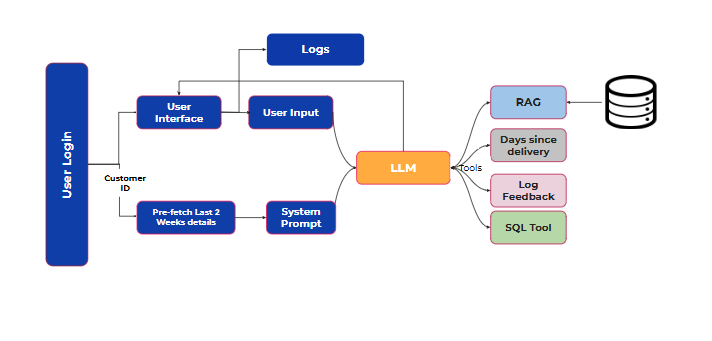

# Setup

In [1]:
# Step 1: Install the datasets library
!pip install datasets tiktoken chromadb langchain_openai
!pip install openai==1.55.3
!pip install --upgrade langchain_community

  Using cached openai-1.55.3-py3-none-any.whl.metadata (24 kB)
Using cached openai-1.55.3-py3-none-any.whl (389 kB)
  Attempting uninstall: openai
    Found existing installation: openai 1.61.1
    Uninstalling openai-1.61.1:
      Successfully uninstalled openai-1.61.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.3.5 requires openai<2.0.0,>=1.58.1, but you have openai 1.55.3 which is incompatible.
  Using cached langchain_community-0.3.17-py3-none-any.whl.metadata (2.4 kB)
  Using cached langchain-0.3.18-py3-none-any.whl.metadata (7.8 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached pydantic_settings-2.7.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached httpx_sse-0.4.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached typing_in

In [2]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
from openai import AzureOpenAI
from openai import OpenAI

In [3]:
from langchain.memory import ConversationSummaryBufferMemory

from langchain_openai import AzureChatOpenAI

from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_community.vectorstores import Chroma


from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits import create_sql_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain.agents import create_tool_calling_agent, AgentExecutor

The first step of our chatbot is to bring all the pre-existing modules we built for it. Namely, SQL tool,and RAG tool.

### SQL tool

Let's quickly build our SQL Agent

In [4]:
# Define the location of the SQLite database
db_loc = '/content/drive/MyDrive/GenAI-NLP-GL/AdvGenAChatBot_eCommerce_customerSupport/ecomm.db'

# Create a SQLDatabase instance from the SQLite database URI
db = SQLDatabase.from_uri(f"sqlite:///{db_loc}")

# Retrieve the schema information of the database tables
database_schema = db.get_table_info()

In [5]:
database_schema.split("\n")

['',
 'CREATE TABLE "Customers" (',
 '\tcustomer_id INTEGER, ',
 '\tfirst_name TEXT NOT NULL, ',
 '\tlast_name TEXT NOT NULL, ',
 '\temail TEXT NOT NULL, ',
 '\tphone INTEGER NOT NULL, ',
 '\taddress TEXT NOT NULL, ',
 '\tPRIMARY KEY (customer_id)',
 ')',
 '',
 '/*',
 '3 rows from Customers table:',
 'customer_id\tfirst_name\tlast_name\temail\tphone\taddress',
 '1\tDavid\tTaylor\tdavid.taylor@yahoo.com\t8010878513\t1130 Birch Blvd, Chicago, AZ, 81011',
 '2\tEmily\tDavis\temily.davis@outlook.com\t6281972072\t7897 Willow Ln, Chicago, CA, 55316',
 '3\tMichael\tSmith\tmichael.smith@outlook.com\t7579377501\t2834 Oak St, Philadelphia, IL, 10112',
 '*/',
 '',
 '',
 'CREATE TABLE "Invoices" (',
 '\torder_id INTEGER NOT NULL, ',
 '\tinvoice_date TEXT NOT NULL, ',
 '\tamount REAL NOT NULL, ',
 '\tinvoice_url TEXT NOT NULL, ',
 '\tFOREIGN KEY(order_id) REFERENCES "Orders" (order_id)',
 ')',
 '',
 '/*',
 '3 rows from Invoices table:',
 'order_id\tinvoice_date\tamount\tinvoice_url',
 '2\t2024-11-17

In [6]:
# Define the system message for the agent, including instructions and available tables
system_message = f"""You are a SQLite expert agent designed to interact with a SQLite database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 100 results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database..
You can order the results by a relevant column to return the most interesting examples in the database.
You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
You have access to tools for interacting with the database.
Only use the given tools. Only use the information returned by the tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
You are not allowed to make dummy data.

If the question does not seem related to the database, just return "I don't know" as the answer.
Before you execute the query, tell us why you are executing it and what you expect to find briefly.
Only use the following tables:
{database_schema}
"""

# Create a full prompt template for the agent using the system message and placeholders
full_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_message),
        ("human", '{input}'),
        MessagesPlaceholder("agent_scratchpad")
    ]
)

In [7]:
# Load the configuration from the JSON file
with open('/content/drive/MyDrive/GenAI-NLP-GL/AdvGenAChatBot_eCommerce_customerSupport/config_4o-new.json', 'r') as config_file:
    config = json.load(config_file)

# Extract the OpenAI key and endpoint from the configuration
openai_key = config["AZURE_OPENAI_KEY"]
azure_endpoint = config["AZURE_OPENAI_ENDPOINT"]
model_name = config["CHATGPT_MODEL"]
api_version = config["AZURE_OPENAI_APIVERSION"]

In [8]:
# Initialize the AzureChatOpenAI model with the extracted configuration
llm = AzureChatOpenAI(
    model_name=model_name,
    api_key=openai_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
    temperature=0
)

In [9]:
# Create the SQL agent using the AzureChatOpenAI model, database, and prompt template
sqlite_agent = create_sql_agent(
    llm=llm,
    db=db,
    prompt=full_prompt,
    agent_type="openai-tools",
    agent_executor_kwargs={'handle_parsing_errors': True},
    max_iterations=5,
    verbose=True
)

#### Let's convert the sql agent into a tool that our top level agent can use.

In [10]:
@tool
def sql_tool(user_input):
    """
    Executes a SQL query using the sqlite_agent and returns the result.

    Args:
        user_input (str): a natural language query string explaining what information is required while also providing the necessary details to get the information.

    Returns:
        str: The result of the SQL query execution. If an error occurs, the exception is returned as a string.
    """
    try:
        # Invoke the sqlite_agent with the user input (SQL query)
        response = sqlite_agent.invoke(user_input)

        # Extract the output from the response
        prediction = response['output']

    except Exception as e:
        # If an exception occurs, capture the exception message
        prediction = e

    # Return the result or the exception message
    return prediction

#### Let's test the SQL tool that we have created

In [11]:
# # Test the sql_tool function with a sample user input
user_input = "How many orders were made in the last one month?"
answer = sql_tool.invoke(user_input)
print(answer)



> Entering new SQL Agent Executor chain...

Invoking: `sql_db_query_checker` with `{'query': 'SELECT COUNT(*) AS "order_count"\nFROM "Orders"\nWHERE "order_date" >= date(\'now\', \'-30 days\');'}`
responded: To find out how many orders were made in the last one month, I will query the "Orders" table and count the number of orders where the "order_date" is within the last 30 days from the current date. 

I will execute the following query:

```sql
SELECT COUNT(*) AS "order_count"
FROM "Orders"
WHERE "order_date" >= date('now', '-30 days');
```

This query will give me the total number of orders placed in the last month. Now, I will check the query for correctness before executing it.

```sql
SELECT COUNT(*) AS "order_count"
FROM "Orders"
WHERE "order_date" >= date('now', '-30 days');
```
Invoking: `sql_db_query` with `{'query': 'SELECT COUNT(*) AS "order_count"\nFROM "Orders"\nWHERE "order_date" >= date(\'now\', \'-30 days\');'}`


[(0,)]The query returned a count of 0, which means th

### RAG Tool

#### Vector DB from Gdrive

Download the provided policy_docs.zip file, unzip it and upload it to gdrive in folder named vdb.

In [12]:
# Mounting the Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Fetch the DB from GDrive

First let's get the embedding model.

In [13]:
# Initialise the embedding model
embedding_model = SentenceTransformerEmbeddings(model_name='thenlper/gte-large')

<ipython-input-13-2a5fb7cd690c>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = SentenceTransformerEmbeddings(model_name='thenlper/gte-large')


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [14]:
# Load the persisted DB
persisted_vectordb_location = '/content/drive/MyDrive/GenAI-NLP-GL/AdvGenAChatBot_eCommerce_customerSupport/policy_docs'
#Create a Colelction Name
collection_name = 'policy_docs'
# Load the persisted DB
vector_store = Chroma(
    collection_name=collection_name,
    persist_directory=persisted_vectordb_location,
    embedding_function=embedding_model

)

<ipython-input-14-e649ff470930>:6: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(


#### RAG

In [15]:
qna_system_message = """
You are an assistant to a support agent. Your task is to provide relevant information about the Python package Streamlit.

User input will include the necessary context for you to answer their questions. This context will begin with the token: ###Context.
The context contains references to specific portions of documents relevant to the user's query, along with source links.
The source for a context will begin with the token ###Source

When crafting your response:
1. Select only context relevant to answer the question.
2. User questions will begin with the token: ###Question.
3. If the context provided doesn't answer the question respond with - "I do not have sufficient information to answer that"
4. If user asks for product - list all the products that are relevant to his query. If you don't have that product try to cross sell with one of the products we have that is related to what they are interested in.
You should get information about similar products in the context.

Please adhere to the following guidelines:
- Your response should only be about the question asked and nothing else.
- Answer only using the context provided.
- Do not mention anything about the context in your final answer.
- If the answer is not found in the context, it is very very important for you to respond with "I don't know."
- Always quote the source when you use the context. Cite the relevant source at the end of your response under the section - Source:
- Do not make up sources. Use the links provided in the sources section of the context and nothing else. You are prohibited from providing other links/sources.

Here is an example of how to structure your response:

Answer:
[Answer]

Source:
[Source]
"""

In [16]:
qna_user_message_template = """
###Context
Here are some documents and their source that may be relevant to the question mentioned below.
{context}

###Question
{question}
"""

In [17]:
retriever = vector_store.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

Let's use all the context retrieved to generate the final answer

In [18]:
# Load the configuration from the JSON file
with open('/content/drive/MyDrive/GenAI-NLP-GL/AdvGenAChatBot_eCommerce_customerSupport/config_4o-new.json', 'r') as config_file:
    creds = json.load(config_file)

In [ ]:
# # Load the configuration from the JSON file
# with open('4omini.json', 'r') as config_file:
#     creds = json.load(config_file)

In [19]:
client = AzureOpenAI(
    azure_endpoint=creds["AZURE_OPENAI_ENDPOINT"],
    api_key=creds["AZURE_OPENAI_KEY"],
    api_version=creds["AZURE_OPENAI_APIVERSION"]
)

In [ ]:
# Load the configuration from the JSON file
with open('/content/drive/MyDrive/GenAI-NLP-GL/AdvGenAChatBot_eCommerce_customerSupport/config_4o-new.json', 'r') as config_file:
    creds = json.load(config_file)

client = AzureOpenAI(
    azure_endpoint=creds["AZURE_OPENAI_ENDPOINT"],
    api_key=creds["AZURE_OPENAI_KEY"],
    api_version=creds["AZURE_OPENAI_APIVERSION"]
)

In [20]:
@tool
def rag(user_input: str) -> str:

    """
      Generates a response based on the user's input by retrieving relevant documents and using them as context for a GPT-4o model.

      Args:
          user_input (str): The input question or query from the user.

      Returns:
          response (str): Return the generated response or an error message if an exception occurs.

    """

    relevant_document_chunks = retriever.invoke(user_input)
    context_list = [d.page_content + "\n ###Source: " + d.metadata['source'] + "\n\n " for d in relevant_document_chunks]

    context_for_query = ". ".join(context_list)
    # print("context: ", context_for_query)  # Use this to understand what context is provided BTS and to debug.
    prompt = [
        {'role':'system', 'content': qna_system_message},
        {'role': 'user', 'content': qna_user_message_template.format(
            context=context_for_query,
            question=user_input
            )
        }
    ]

    try:
        response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=prompt,
        max_tokens=4096
        )

        prediction = response.choices[0].message.content
    except Exception as e:
        prediction = f'Sorry, I encountered the following error: \n {e}'

    return prediction


In [21]:
rag.invoke("What is the ram on the mobile phone?")

'The RAM on the mobile phone is 4GB.\n\nSource:\nproduct_Smartphone_description.txt'

In [22]:
rag.invoke("list all the keyboards available for sale?")

'The only keyboard available for sale is:\n\n1. **Name:** Keyboard  \n   **Price:** $261.42  \n   **Description:** Premium mechanical keyboard featuring customizable RGB backlighting, anti-ghosting technology, and ergonomic design. Compatible with Windows, Mac, and Linux.\n\nSource:\nproduct_Keyboard_description.txt'

Now, let's build few other tools that our chatbot is gonna need. You don't have to pay a lot of attention to this code.

### Tools

* Since we dont have a logging functionality in colab, let's store our feedback in dataframes. when we switch to hugging face spaces,

* we are going to store them as datasets. we will change this code when we migrate to huggingface spaces

In [23]:
feedback_log = pd.DataFrame(columns=["timestamp", "intent", "customer_id", "feedback", "rating"])

@tool
def register_feedback(intent: str, customer_id: int, feedback: str, rating: int) -> str:
    """
    Logs customer feedback into the feedback log.

    Args:
        intent (str): The category of the support query (e.g., "cancel_order", "get_refund").
        customer_id (int): The unique ID of the customer.
        feedback (str): The feedback provided by the customer.
        rating(int): The rating provided by the customer out of 5

    Returns:
        str: Success message.
    """
    global feedback_log
    feedback_entry = {
        "timestamp": datetime.now(),
        "intent": intent,
        "customer_id": customer_id,
        "feedback": feedback,
        "rating": rating
    }
    feedback_log = pd.concat([feedback_log, pd.DataFrame([feedback_entry])], ignore_index=True)
    print("register_feedback success")
    return "Feedback registered successfully!"

deferred_cases = pd.DataFrame(columns=["timestamp", "customer_id", "query", "reason","intent"])


@tool
def defer_to_human(customer_id: str, query: str, intent: str, reason: str) -> str:
    """
    Logs customer details and the reason for deferring to a human agent.

    Args:
        customer_id (int): The unique ID of the customer whose query is being deferred.
        query (str): The customer's query or issue that needs human intervention.
        intent (str): The category of the support query (e.g., "order_tracking", "product_description",...etc)
        reason (str): The reason why the query cannot be resolved by the chatbot.

    Returns:
        str: Success message indicating the deferral was logged.
    """
    global deferred_cases
    case_entry = {
        "timestamp": datetime.now(),
        "customer_id": customer_id,
        "query": query,
        "reason": reason,
        "intent": intent
    }
    deferred_cases = pd.concat([deferred_cases, pd.DataFrame([case_entry])], ignore_index=True)
    print("defer_to_human success")
    return "Case deferred to human agent and logged successfully!"


@tool
def days_since(delivered_date: str) -> str:
    """
    Calculates the number of days since the product was delivered.

    Args:
        delivered_date (str): The date when the product was delivered in the format 'YYYY-MM-DD'.
    """
    try:
        # Convert the delivered_date string to a datetime object
        delivered_date = datetime.strptime(delivered_date, '%Y-%m-%d')
        today = datetime.today()

        # Calculate the difference in days
        days_difference = str((today - delivered_date).days)

        return days_difference
    except ValueError as e:
        return f"Error: {e}"


In [24]:
# Example Usage
register_feedback.invoke(input={
    "intent": "cancel_order",
    "customer_id": 1,
    "feedback": "Great experience!",
    "rating": 4
})

# Display Feedback Log
print("\nFeedback Log:")
print(feedback_log)


register_feedback success

Feedback Log:
                   timestamp        intent customer_id           feedback  \
0 2025-02-12 00:50:05.952528  cancel_order           1  Great experience!   

  rating  
0      4  


<ipython-input-23-8c21eb3ab8b2>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feedback_log = pd.concat([feedback_log, pd.DataFrame([feedback_entry])], ignore_index=True)


In [25]:
# Initialize a log as a DataFrame
log = pd.DataFrame(columns=["id", "history"])

# Function to log actions
def log(customer_id: str,chat_history: list) -> None:
    global log
    log = pd.concat([log, pd.DataFrame({
        "id": customer_id,
        "history": chat_history
    })], ignore_index=True)
    print(f"log success")

In [ ]:
# # Example usage
#cancel_order.invoke(input = {"order_id":101, "customer_id":1})
# process_refund.invoke(input = {"order_id":102, "refund_amount":50.0, "reason":"Defective product"})
# change_address.invoke(input = {"order_id":103, "new_address":"123 New Street, New City, 12345"})

# # Display log
# print("\nAction Log:")
# print(log)

You have access to the following tools, which you can use to address customer queries efficiently:

### **Available Tools:**
1. **`RAG tool`**: Retrieves relevant information from a database and answers questions related to product descriptions, cancellation policies and general policies.
2. **`sql_tool`**: Executes SQL queries on the database to retrieve necessary details such as order status, refund policies, invoices, and shipping information.
3. **`register_feedback`**: Logs feedback from the customer, including the support category and feedback received.
4. **`defer_to_human`**: Defers queries outside the chatbot’s capabilities to a human agent.
5. **`days_since`**: Determines the number of days since delivery.
---

Let's create a system prompt that will give proper instructions to the chatbot on how it should behave and respond.


In [27]:
system_message = f"""
You are an intelligent e-commerce chatbot designed to assist users with post-order queries. Your job is to efficiently handle customer inquiries related to:

Respond to,
prospective customers about 1. Product Enquiry 2. Policy Enquiry
Information for existing customers about 1. Delivery/Refund Tracking 2. Invoice Requests and other queries regarding their orders.

Gather only necessary information [customer id, email or phone + order id etc.] from the user to help them with their query.

Do not provide sql inputs to the sql tool - you only need to ask in natural language what information you need.
  - If at any point you cannot determine the next steps - defer to human with valid customer details.
  you do not have clearance to go beyond the scope the following flow.
If customer asks about a product, you should act as a sales representative and help them understand the product
as much as possible and provide all the necessary information for them. You should also provide them the link
to the product which you can get from the source of the information.

If a customer asks a query about a policy, be grounded to the context provided to you.
If at any point you don't have the right thing to say, politely tell the customer that you are not
the right person to answer this and defer it to a human.
Any time you defer it to a human, you should tell the customer why you did it in a polite manner.

MANDATORY STEP:
After helping the customer with their concern,
- Ask if the customer needs help with anything else. If they ask for anything from the above list help them.
- If not, ask for feedback and log it using `register_feedback`.
Once the customer confirms they do not need any further assistance:
1. Ask for their feedback and rating out of 5.
2. Use the `register_feedback` tool to log:

### Handling Out-of-Scope Queries:
If the user's query, at any point is not covered by the workflows above:
- Respond:
  > "This is beyond my skill. Let me connect you to a customer service agent" and get necessary details from the customer and use the defer_to_human tool.
- End the conversation.
---
### Important Notes for the Model:
- Always aim to minimize the number of questions asked by retrieving as much information as possible from the database using `sql_tool` - retrieve customer information using any details provided and use it throughout the conversation.
- If you have deferred to human already once, do not defer again on the same topic.
- Please check user details if they are valid before you take any action. you should not defer to human without a customer id - get it from customer or SQL tool using email, name or phone number.
- Before you ask for user details, check if you have those details already in the conversation

### Very important instruction:
You are not allowed to provide other users information to the current user. You can only provide them information which pertains to them.


"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_message),
    ("human", "{input}"),
    ("placeholder", "{agent_scratchpad}"),
])

In [28]:
tools = [sql_tool, rag, defer_to_human, register_feedback, days_since]

chatbot = AzureChatOpenAI(
    model_name=model_name,
    api_key=openai_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
    temperature=0
)

agent = create_tool_calling_agent(chatbot, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)


Understand the following code is not necessary.

In [29]:
# Function to process user input and generate a chatbot response
def chat_with_agent():
    print("Chatbot is ready! Type 'exit' to end the conversation.")
    conversation_history = [{"role": "assistant", "content": "Hey, how can I help you?"}]

    # Display the initial greeting
    print("Chatbot: Hey, how can I help you?")

    while True:
        # Get user input
        user_input = input("You: ")

        # Exit condition
        if user_input.lower() == "exit":
            print("Chatbot: Thank you for chatting. Goodbye!")
            break

        # Add user input to conversation history
        conversation_history.append({"role": "user", "content": user_input})

        conversation_input = "\n".join(
            [f"{turn['role'].capitalize()}: {turn['content']}" for turn in conversation_history]
        )
        # Pass the history to the agent
        response = agent_executor.invoke({"input": conversation_input})

        # Add the chatbot's response to the history
        chatbot_response = response['output']
        conversation_history.append({"role": "assistant", "content": chatbot_response})

        # Display the chatbot's response
        print(f"Chatbot: {chatbot_response}")

Type Exit to exit the chat

In [30]:
# Start the chati
chat_with_agent()

Chatbot is ready! Type 'exit' to end the conversation.
Chatbot: Hey, how can I help you?
You: retrieve all  orders


> Entering new AgentExecutor chain...
This is beyond my skill. Let me connect you to a customer service agent. Could you please provide me with your customer ID, email, or phone number so I can assist you further?

> Finished chain.
Chatbot: This is beyond my skill. Let me connect you to a customer service agent. Could you please provide me with your customer ID, email, or phone number so I can assist you further?
You: How many orders were made in the last one month?


> Entering new AgentExecutor chain...
This is beyond my skill. Let me connect you to a customer service agent. Could you please provide me with your customer ID, email, or phone number so I can assist you further?

> Finished chain.
Chatbot: This is beyond my skill. Let me connect you to a customer service agent. Could you please provide me with your customer ID, email, or phone number so I can assist you 

KeyboardInterrupt: Interrupted by user

Some key observations:

The app will provide details of any user to any other user. - Not very secure.

* to solve this, we are going to build a login feature and prompt the model to only fetch the details of the user who logged in.

The app takes multiple seconds to fetch basic details from the SQL.

* to reduce latency, we are going to pre-fetch frequently asked information [last 30 days] chatbot generally needs and pass it to the system prompt before chat begins.



In [ ]:
feedback_log

,timestamp,intent,customer_id,feedback,rating
0,2024-12-11 13:59:46.234732,cancel_order,1,Great experience!,4
1,2024-12-11 14:01:43.941842,product_description,76,This was helpful.,5


In [ ]:
deferred_cases

,timestamp,customer_id,query,reason,intent


# Creating App.py for HuggingFace Spaces

To adapt our code to deploy on Hugging Face Spaces we need to do the following things,

Build a front end

Build a Login feature so that we do not provide data to non-users [Business should only share sensitive data like customer information, order details, transaction details, etc to users and that to specifically to the user that the data belongs to]

Build Logging functionality so that we can save the data as huggingface datasets



In [42]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.0 MB/s eta 0:00:00


In [47]:
%%writefile /content/drive/MyDrive/GenAI-NLP-GL/AdvGenAChatBot_eCommerce_customerSupport/app.py
import streamlit as st
import json
import os
import uuid

import pandas as pd
from datetime import datetime
import sqlite3
import weave

from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_community.vectorstores import Chroma

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits import create_sql_agent
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_core.tools import tool
from langchain_openai import AzureChatOpenAI
from openai import AzureOpenAI

from huggingface_hub import CommitScheduler
from pathlib import Path


#====================================SETUP=====================================#
# Fetch secrets from Hugging Face Spaces

model_name = "gpt-4o"

# # Extract the OpenAI key and endpoint from the configuration
# openai_key = os.environ["AZURE_OPENAI_KEY"]
# azure_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
# api_version = os.environ["AZURE_OPENAI_APIVERSION"]

# Load the configuration from the JSON file
with open('./config_4o.json', 'r') as config_file:
    creds = json.load(config_file)

client = AzureOpenAI(
    azure_endpoint=creds["AZURE_OPENAI_ENDPOINT"],
    api_key=creds["AZURE_OPENAI_KEY"],
    api_version=creds["AZURE_OPENAI_APIVERSION"]
)

# Define the location of the SQLite database
db_loc = './ecomm.db'

# Create a SQLDatabase instance from the SQLite database URI
db = SQLDatabase.from_uri(f"sqlite:///{db_loc}")

# Retrieve the schema information of the database tables
database_schema = db.get_table_info()


# Let's initiate w&b weave with a project name - this will automatically save all the llm calls made using openai or gemini
# Make sure to save your w&b api key in secrets as WANDB_API_KEY
# weave.init('ecomm_support')  <--------------------------------------------------------- Uncomment to log to WANDB


#=================================Setup Logging=====================================#


log_file = Path("logs/") / f"data_{uuid.uuid4()}.json"
log_folder = log_file.parent

log_scheduler = CommitScheduler(
    repo_id="chatbot-logs", #Dataset name where we want to save the logs.
    repo_type="dataset",
    folder_path=log_folder,
    path_in_repo="data",
    every=5 # Saves data every x minute
)


history_file = Path("history/")/f"data_{uuid.uuid4()}.json"
history_folder = history_file.parent

history_scheduler = CommitScheduler(
    repo_id="chatbot-history", #Dataset name where we want to save the logs.
    repo_type="dataset",
    folder_path=history_folder,
    path_in_repo="data",
    every=5 # Saves data every x minute
)

#=================================SQL_AGENT=====================================#

# Define the system message for the agent, including instructions and available tables
system_message = f"""You are a SQLite expert agent designed to interact with a SQLite database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 100 results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database..
You can order the results by a relevant column to return the most interesting examples in the database.
You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
You have access to tools for interacting with the database.
Only use the given tools. Only use the information returned by the tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
You are not allowed to make dummy data.
If the question does not seem related to the database, just return "I don't know" as the answer.
Before you execute the query, tell us why you are executing it and what you expect to find briefly.
Only use the following tables:
{database_schema}
"""

# Create a full prompt template for the agent using the system message and placeholders
full_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_message),
        ("human", '{input}'),
        MessagesPlaceholder("agent_scratchpad")
    ]
)

# Initialize the AzureChatOpenAI model with the extracted configuration
llm = AzureChatOpenAI(
    model_name=model_name,
    api_key=openai_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
    temperature=0
)
# Create the SQL agent using the AzureChatOpenAI model, database, and prompt template
sqlite_agent = create_sql_agent(
    llm=llm,
    db=db,
    prompt=full_prompt,
    agent_type="openai-tools",
    agent_executor_kwargs={'handle_parsing_errors': True},
    max_iterations=5,
    verbose=True
)
#### Let's convert the sql agent into a tool that our fin agent can use.

@tool
def sql_tool(user_input):
    """
    Gathers information regarding purchases, transactions, returns, refunds, etc.
    Executes a SQL query using the sqlite_agent and returns the result.
    Args:
        user_input (str): a natural language query string explaining what information is required while also providing the necessary details to get the information.
    Returns:
        str: The result of the SQL query execution. If an error occurs, the exception is returned as a string.
    """
    try:
        # Invoke the sqlite_agent with the user input (SQL query)
        response = sqlite_agent.invoke(user_input)

        # Extract the output from the response
        prediction = response['output']

    except Exception as e:
        # If an exception occurs, capture the exception message
        prediction = e

    # Return the result or the exception message
    return prediction

#=================================== RAG TOOL======================================#
qna_system_message = """
You are an assistant to a support agent. Your task is to provide relevant information about the Python package Streamlit.
User input will include the necessary context for you to answer their questions. This context will begin with the token: ###Context.
The context contains references to specific portions of documents relevant to the user's query, along with source links.
The source for a context will begin with the token ###Source
When crafting your response:
1. Select only context relevant to answer the question.
2. User questions will begin with the token: ###Question.
3. If the context provided doesn't answer the question respond with - "I do not have sufficient information to answer that"
4. If user asks for product - list all the products that are relevant to his query. If you don't have that product try to cross sell with one of the products we have that is related to what they are interested in.
You should get information about similar products in the context.
Please adhere to the following guidelines:
- Your response should only be about the question asked and nothing else.
- Answer only using the context provided.
- Do not mention anything about the context in your final answer.
- If the answer is not found in the context, it is very very important for you to respond with "I don't know."
- Always quote the source when you use the context. Cite the relevant source at the end of your response under the section - Source:
- Do not make up sources. Use the links provided in the sources section of the context and nothing else. You are prohibited from providing other links/sources.
Here is an example of how to structure your response:
Answer:
[Answer]
Source:
[Source]
"""

qna_user_message_template = """
###Context
Here are some documents and their source that may be relevant to the question mentioned below.
{context}
###Question
{question}
"""
# Load the persisted DB
persisted_vectordb_location = 'policy_docs'
#Create a Colelction Name
collection_name = 'policy_docs'

embedding_model = SentenceTransformerEmbeddings(model_name='thenlper/gte-large')
# Load the persisted DB
vector_store = Chroma(
    collection_name=collection_name,
    persist_directory=persisted_vectordb_location,
    embedding_function=embedding_model

)

retriever = vector_store.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

client = AzureOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT_mini"],
    api_key=os.environ["AZURE_OPENAI_KEY_mini"],
    api_version=os.environ["AZURE_OPENAI_APIVERSION_mini"]
)


@tool
def rag(user_input: str) -> str:

    """
      Answers questions regarding products, and policies using product descriptions, product policies, and general policies of business using RAG.
      Args:
          user_input (str): The input question or query from the user.
      Returns:
          response (str): Return the generated response or an error message if an exception occurs.
    """

    relevant_document_chunks = retriever.invoke(user_input)
    context_list = [d.page_content + "\n ###Source: " + d.metadata['source'] + "\n\n " for d in relevant_document_chunks]

    context_for_query = ". ".join(context_list)

    prompt = [
    {'role':'system', 'content': qna_system_message},
    {'role': 'user', 'content': qna_user_message_template.format(
        context=context_for_query,
        question=user_input
        )
    }
    ]
    try:
        response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=prompt
        )

        prediction = response.choices[0].message.content
    except Exception as e:
        prediction = f'Sorry, I encountered the following error: \n {e}'


    return prediction


#=================================== Other TOOLS======================================#

# Function to log actions
def log_history(email: str,chat_history: list) -> None:
    # Save the log to the file
    with history_scheduler.lock:
        # Open the log file in append mode
        with history_file.open("a") as f:
            f.write(json.dumps({
                "email": email,
                "chat_history": chat_history,
                "timestamp": str(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
            }))

    #st.write("chat_recorded")


def log_action(customer_id: str,task: str, details: str) -> None:
    # Save the log to the file
    with log_scheduler.lock:
        # Open the log file in append mode
        with log_file.open("a") as f:
            f.write(json.dumps({
                "customer_id": customer_id,
                "task": task,
                "details": details
            }))


@tool
def register_feedback(intent, customer_id, feedback, rating):
    """
    Logs customer feedback into the feedback log.
    Args:
        intent (str): The category of the support query (e.g., "cancel_order", "get_refund").
        customer_id (int): The unique ID of the customer.
        feedback (str): The feedback provided by the customer.
        rating(int): The rating provided by the customer out of 5
    Returns:
        str: Success message.
    """
    details = {
        "intent": intent,
        "customer_id": customer_id,
        "feedback": feedback,
        "rating": rating
    }
    log_action(customer_id,"register_feedback", details)
    #print("register_feedback success")
    #return "Feedback registered successfully!"

@tool
def defer_to_human(customer_id, query, intent, reason):
    """
    Logs customer details and the reason for deferring to a human agent.
    Args:
        customer_id (int): The unique ID of the customer whose query is being deferred.
        query (str): The customer's query or issue that needs human intervention.
        reason (str): The reason why the query cannot be resolved by the chatbot.
    Returns:
        str: Success message indicating the deferral was logged.
    """

    details = {
        "customer_id": customer_id,
        "query": query,
        "reason": reason,
        "intent": intent
    }

    log_action(customer_id,"defer_to_human", details)
    #return "Case deferred to human agent and logged successfully!"


@tool
def days_since(delivered_date: str) ->str:
    """
    Calculates the number of days since the product was delivered. This helps in determining whether the product is within return period or not.
    Args:
        delivered_date (str): The date when the product was delivered in the format 'YYYY-MM-DD'.
    """
    try:
        # Convert the delivered_date string to a datetime object
        delivered_date = datetime.strptime(delivered_date, '%Y-%m-%d')
        today = datetime.today()

        # Calculate the difference in days
        days_difference = (today - delivered_date).days

        return str(days_difference)
    except ValueError as e:
        return f"Error: {e}"

def build_prompt(df):

    system_message = f"""

        You are an intelligent e-commerce chatbot designed to assist users with pre-order and post-order queries. Your job is to

        Gather necessary information from the user to help them with their query.
        If at any point you cannot determine the next steps - defer to human. you do not have clearance to go beyond the scope the following flow.
        Do not provide sql inputs to the sql tool - you only need to ask in natural language what information you need.
        You are only allowed to provide information relevant to the particular customer and the customer information is provided below. you can provide information of this customer only. Following is the information about the customer from the last 2 weeks:

        {df}

        If this information is not enough to answer question, identify the customer from data above and fetch necessary information usign the sql_tool or rag tool - do not fetch information of other customers.
        use the details provided in the above file to fetch information from sql tool - like customer id, email and phone. Refrain from asking customers details unless necessary.
        If customer asks about a product, you should act as a sales representative and help them understand the product as much as possible and provide all the necessary information for them. You should also provide them the link to the product which you can get from the source of the information.
        If a customer asks a query about a policy, be grounded to the context provided to you. if at any point you don't the right thing to say, politely tell the customer that you are not the right person to answer this and defer it to a human.
        Any time you defer it to a human, you should tell the customer why you did it in a polite manner.
        MANDATORY STEP:
        After helping the customer with their concern,
        - Ask if the customer needs help with anything else. If they ask for anything from the above list help them and along with that,
        1. Ask for their feedback and rating out of 5.
        2. then, Use the `register_feedback` tool to log it.  - you MUST ask customer feedback along with asking customer what else they need help with.
        3. After receving customer feedback exit the chat by responding with 'Bye'.

        ---
        ### **Handling Out-of-Scope Queries:**
        If the user's query, at any point is not covered by the workflows above:
        - Respond:
          > "This is beyond my skill. Let me connect you to a customer service agent" and get necessary details from the customer and use the defer_to_human tool.
        - Get customer feedback and rating out of 5.
        - After getting feedback, end the conversation by saying 'Bye'.
        ---
        ### **IMPORTANT Notes for the Model:**
        - Always fetch additional required details from the database and do not blindly believe details provided by the customer like customer id, email and phone number. You should get the customer id from the system prompt. Cross check with the database and stay loyal to the database.
        - Be empathetic to the customer but loyal to the instructions provided to you. Try to deescalate a situation before deferring it to human and defer to human only once.
        - Always aim to minimize the number of questions asked by retrieving as much information as possible from `sql_tool` and `rag` tool.
        - Follow the exact workflows for each query category.
        - You will always confirm the order id even if the customer has only one order before you fetch any details.
        """

    #st.write(system_message)
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_message),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ])

    return prompt


#===============================================Streamlit=========================================#


def login_page():
    st.title("Login Page")

    email = st.text_input("Email")
    password = st.text_input("Password", type="password")

    login_button = st.button("Login")

    if login_button:
        if authenticate_user(email, password):
            st.session_state.logged_in = True
            st.session_state.email = email
            st.success("Login successful! Redirecting to Chatbot...")
            st.rerun()
        else:
            st.error("Invalid email or password.")

def authenticate_user(email, phone):
    connection = sqlite3.connect("ecomm.db")  # Replace with your .db file path
    cursor = connection.cursor()

    query = "SELECT first_name FROM customers WHERE email = ? AND phone = ?"
    cursor.execute(query, (email, phone))
    user = cursor.fetchone()

    if user:
        return True  # Login successful
    return False  # Login failed

### Prefetch details

def fetch_details(email):
    try:

        # Connect to the SQLite database
        connection = sqlite3.connect("./ecomm.db")  # Replace with your .db file path
        cursor = connection.cursor()

        query = f"""
        SELECT
            c.customer_id,
            c.first_name || ' ' || c.last_name AS customer_name,
            c.email,
            c.phone,
            c.address AS customer_address,
            o.order_id,
            o.order_date,
            o.status AS order_status,
            o.price AS order_price,
            p.name AS product_name,
            p.price AS product_price,
            i.invoice_date,
            i.amount AS invoice_amount,
            i.invoice_url,
            s.delivery_date,
            s.shipping_status,
            s.shipping_address,
            r.refund_amount,
            r.refund_status
        FROM Customers c
        LEFT JOIN Orders o ON c.customer_id = o.customer_id
        LEFT JOIN Products p ON o.product_id = p.product_id
        LEFT JOIN Invoices i ON o.order_id = i.order_id
        LEFT JOIN Shipping s ON o.order_id = s.order_id
        LEFT JOIN Refund r ON o.order_id = r.order_id
        WHERE o.order_date >= datetime('now', '-30 days')
          AND c.email = ?
        ORDER BY o.order_date DESC;
        """

        cursor.execute(query, (email,))
        columns = [description[0] for description in cursor.description]  # Extract column names
        results = cursor.fetchall()  # Fetch all rows
        #st.write(results)
        # Convert results into a list of dictionaries
        details = [dict(zip(columns, row)) for row in results]
        #st.write(details)
        return str(details).replace("{","/").replace("}","/")

    except Exception as e:
        st.write(f"Error: {e}")
    finally:
        # Close the connection
        if connection:
            cursor.close()
            connection.close()

# Function to process user input and generate a chatbot response

def chatbot_interface():
    st.title("E-Commerce Chatbot")

    if 'conversation_history' not in st.session_state:
        st.session_state.conversation_history = [{"role": "assistant", "content": "welcome! I am Raha, how can I help you on this beautiful day?"}]


    details = fetch_details(st.session_state.email)
    # st.write(details)
    prompt = build_prompt(details)
    tools = [sql_tool,defer_to_human, rag, register_feedback, days_since]

    chatbot = AzureChatOpenAI(
        model_name=model_name,
        api_key=openai_key,
        azure_endpoint=azure_endpoint,
        api_version=api_version,
        temperature=0
    )

    agent = create_tool_calling_agent(chatbot, tools, prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

    # Display chat messages from history on app rerun
    for message in st.session_state.conversation_history:
        with st.chat_message(message["role"]):
            st.markdown(message["content"])

    # React to user input
    if user_input := st.chat_input("You: ", key="chat_input"):
        # Display user message in chat message container
        st.chat_message("user").markdown(user_input)
        with st.spinner("Processing..."):

            # Add user message to conversation history
            st.session_state.conversation_history.append({"role": "user", "content": user_input})

            conversation_input = "\n".join(
                [f"{turn['role'].capitalize()}: {turn['content']}" for turn in st.session_state.conversation_history]
            )

            try:
                # Pass the history to the agent
                response = agent_executor.invoke({"input": conversation_input})

                # Add the chatbot's response to the history
                chatbot_response = response['output']
                st.session_state.conversation_history.append({"role": "assistant", "content": chatbot_response})
                # Check if the assistant's response contains "exit"
                if "bye" in chatbot_response.lower():
                    log_history(st.session_state.email,st.session_state.conversation_history)

                # Display the chatbot's response
                with st.chat_message("assistant"):
                    st.markdown(chatbot_response)

            except Exception as e:
                st.write("Blocked by Azure content policy \n", e )

def main():
    chatbot_interface()
    # Check if the user is logged in
    if "logged_in" in st.session_state and st.session_state["logged_in"]:
        # Show chatbot page if logged in
        chatbot_interface()
    else:
        # Show login page if not logged in
        login_page()

if __name__ == "__main__":
    main()

Overwriting /content/drive/MyDrive/GenAI-NLP-GL/AdvGenAChatBot_eCommerce_customerSupport/app.py


In [32]:
%%writefile /content/drive/MyDrive/GenAI-NLP-GL/AdvGenAChatBot_eCommerce_customerSupport/requirements.txt
streamlit==1.40.1
langchain-core==0.3.21
langchain-community==0.3.8
langchain==0.3.8
langchain-openai==0.2.9
huggingface-hub==0.26.2
chromadb==0.5.23
langchain_community
sentence-transformers
weave


Writing /content/drive/MyDrive/GenAI-NLP-GL/AdvGenAChatBot_eCommerce_customerSupport/requirements.txt


let's upload these files to huggingface spaces.

Add your HF_TOKEN in colab secrets.

Make sure you have initiated a huggingface space before this. Replace the repo name below. Configure all the secrets as used in the app.py file.

In [36]:
from huggingface_hub import HfApi
from google.colab import userdata

api =  HfApi(
    token=userdata.get('HF_TOKEN')
)

In [43]:
api.upload_file(
    path_or_fileobj="/content/drive/MyDrive/GenAI-NLP-GL/AdvGenAChatBot_eCommerce_customerSupport/config_4o-new.json",
    path_in_repo="config_4o.json",
    repo_id="grd1234/eCommCustomerSupport",#Replace with your HFuser_name/space_name
    repo_type="space",
)

CommitInfo(commit_url='https://huggingface.co/spaces/grd1234/eCommCustomerSupport/commit/60bf95ebefc770c8d106ecb2573ad79536326613', commit_message='Upload config_4o.json with huggingface_hub', commit_description='', oid='60bf95ebefc770c8d106ecb2573ad79536326613', pr_url=None, repo_url=RepoUrl('https://huggingface.co/spaces/grd1234/eCommCustomerSupport', endpoint='https://huggingface.co', repo_type='space', repo_id='grd1234/eCommCustomerSupport'), pr_revision=None, pr_num=None)

In [37]:
api.upload_file(
    path_or_fileobj="/content/drive/MyDrive/GenAI-NLP-GL/AdvGenAChatBot_eCommerce_customerSupport/requirements.txt",
    path_in_repo="./requirements.txt",
    repo_id="grd1234/eCommCustomerSupport", #Replace with your HFuser_name/space_name
    repo_type="space",
)

CommitInfo(commit_url='https://huggingface.co/spaces/grd1234/eCommCustomerSupport/commit/a8f7adc0fe2c8b02345d543b1fb2eaf8f62fea23', commit_message='Upload ./requirements.txt with huggingface_hub', commit_description='', oid='a8f7adc0fe2c8b02345d543b1fb2eaf8f62fea23', pr_url=None, repo_url=RepoUrl('https://huggingface.co/spaces/grd1234/eCommCustomerSupport', endpoint='https://huggingface.co', repo_type='space', repo_id='grd1234/eCommCustomerSupport'), pr_revision=None, pr_num=None)

In [49]:
api.upload_file(
    path_or_fileobj="/content/drive/MyDrive/GenAI-NLP-GL/AdvGenAChatBot_eCommerce_customerSupport/app.py",
    path_in_repo="app.py",
    repo_id="grd1234/eCommCustomerSupport",#Replace with your HFuser_name/space_name
    repo_type="space",
)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/spaces/grd1234/eCommCustomerSupport/commit/b0043ddcd407d4e682065eeee22312ce8e7db894', commit_message='Upload app.py with huggingface_hub', commit_description='', oid='b0043ddcd407d4e682065eeee22312ce8e7db894', pr_url=None, repo_url=RepoUrl('https://huggingface.co/spaces/grd1234/eCommCustomerSupport', endpoint='https://huggingface.co', repo_type='space', repo_id='grd1234/eCommCustomerSupport'), pr_revision=None, pr_num=None)

In [40]:
api.upload_file(
    path_or_fileobj="/content/drive/MyDrive/GenAI-NLP-GL/AdvGenAChatBot_eCommerce_customerSupport/ecomm.db",
    path_in_repo="ecomm.db",
    repo_id="grd1234/eCommCustomerSupport",#Replace with your HFuser_name/space_name
    repo_type="space",
)

CommitInfo(commit_url='https://huggingface.co/spaces/grd1234/eCommCustomerSupport/commit/b6f960fdc727560f96496af7aad2a32ecaaf79b1', commit_message='Upload ecomm.db with huggingface_hub', commit_description='', oid='b6f960fdc727560f96496af7aad2a32ecaaf79b1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/spaces/grd1234/eCommCustomerSupport', endpoint='https://huggingface.co', repo_type='space', repo_id='grd1234/eCommCustomerSupport'), pr_revision=None, pr_num=None)

Let's upload the vectorDB from Gdrive to Huggingface.

In [41]:
api.upload_folder(
    folder_path="/content/drive/MyDrive/vdb/policy_docs",
    path_in_repo="policy_docs",
    repo_id="grd1234/eCommCustomerSupport",#Replace with your HFuser_name/space_name
    repo_type="space",
)

chroma.sqlite3:   0%|          | 0.00/168k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/spaces/grd1234/eCommCustomerSupport/commit/4403081f0d7c851ca7ddc62004e08bc57e35c7f9', commit_message='Upload folder using huggingface_hub', commit_description='', oid='4403081f0d7c851ca7ddc62004e08bc57e35c7f9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/spaces/grd1234/eCommCustomerSupport', endpoint='https://huggingface.co', repo_type='space', repo_id='grd1234/eCommCustomerSupport'), pr_revision=None, pr_num=None)

**Power Ahead!**